# Train the VOLVuLuS model
Train the VOLumetric VesseL Segmentation (VOLVuLuS) model, a variant of the 3D U-Net by ([Çiçek 2016](#References)). The training set comprises **volumes of** (as opposed to **individual** images used by DECiSION) 320 by 320 pixels grayscale axial MRI images along with ground truth images highlighting blood vessels associated with each MRI image. The trained model can be applied to (unseen) MRI images to produce segmentation maps using `VOLVuLuS_test.ipynb`.

# Set seeds and import packages
Setting the seeds first is meant to achieve reproducibility, though this goal is not entirely achieved.

In [1]:
RANDOM_STATE = 42
from numpy.random import seed
seed(RANDOM_STATE)

from tensorflow import set_random_seed
set_random_seed(RANDOM_STATE)

import random
random.seed = RANDOM_STATE

# Model and training settings
import VOLVuLuS_settings as settings

# Toolkit imports
from dltoolkit.utils.generic import model_architecture_to_file, model_summary_to_file, list_images
from dltoolkit.nn.segment import UNet_3D_NN
from dltoolkit.utils.visual import plot_training_history, plot_roc_curve,\
    plot_precision_recall_curve, print_confusion_matrix, print_classification_report
from dltoolkit.iomisc import HDF5Generator_Segment

from thesis_common import convert_img_to_pred_3d, convert_pred_to_img_3d, create_hdf5_db_3d,\
    show_image, read_images, read_groundtruths, print_training_info
from thesis_metric_loss import dice_coef, weighted_pixelwise_crossentropy_loss

# Keras imports
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# scikit-learn imports
from sklearn.model_selection import train_test_split

# Other imports
import numpy as np
import os, cv2, time, progressbar
import matplotlib.pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Change how TensorFlow allocates GPU memory
Setting `gpu_options.allow_growth` to `True` means TensorFlow will allocate GPU memory as needed rather than using all available memory from the start. This enables monitoring of actual memory usage and determining how close the notebook gets to running out of memory. This has no effect on non-GPU machines.

In [2]:
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
 
# Only allow a percentage of the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified
k.tensorflow_backend.set_session(tf.Session(config=config))

# Determine training settings
The variables below determine how the model will be trained:

- `USE_VALIDATION_SET`: set to `True` to use a validation set during training, which will be the case most of the time. set to `False` to not use a validation set, e.g. during pipeline development/validation.
- `IS_DEVELOPMENT`: set to `True` to re-create the HDF5 files every time training is executed, `False` otherwise.

Contrary to DECiSION, VOLVuLuS always uses data generators due to the size of the model.

**Note** if `TRN_TRAIN_VAL_SPLIT` is set to 0, a validation set will *not* be created, even if `USE_VALIDATION_SET` is set to `True`. In fact, `USE_VALIDATION_SET` will be set to `False`.

In [3]:
USE_VALIDATION_SET = False
IS_DEVELOPMENT = True

# Convert individual JPGs to HDF5 data sets
This function converts individual JPG files to HDF5 data sets. It creates up to four HDF5 files depending on whether a portion of the files is set aside as a validation set using the `settings.TRN_TRAIN_VAL_SPLIT` parameter.

This conversion only has to be performed once rather than prior to every training run. However, it takes very little time to run. **Note**: if any changes are made to image pre-processing applied to MRI images and/or their ground truths, the conversion MUST be executed prior to the next training run. Failing to do this means training will be performed on existing HDF5 data sets that do not include the revised pre-processing.

The folder stucture is shown below. MRI images (i.e. the individial JPG files, one for each *slice*) are located in the `images` folder. Each patient has a separate subfolder. Ground truths are located in the `groundtruths` folder, again each patient has a separate subfolder. The association between MRI image and ground truth is based on the name of the patient's subfolder **and** the alphabetically sorted file name. An entire volume of MRI images/ground truths pair constitutes one training sample. The resulting HDF5 data sets are stored in the `images` and `ground truths` subfolders. The training data sets are called `train_images.h5` and `train_groundtruths.h5`. The validation sets, if they were created, are called `val_images.h5` and `val_groundtruths.h5`.

**Note**: VOLVuLuS (`training3d`) and DECiSION (`training`) use different folders to store their training data. They could both use the same training data. However, keeping them separate ensures changes applied to the training set (e.g. pre-processing techniques, different cropping settings etc.) used by one model does not affect the other model.  

```
---training3d
|     |--- images
|     |      |---patient1
|     |      |      |--- image1
|     |      |      |--- image2
|     |      |      ...
|     |      |      |--- imageM
|     |      |---patient2
|     |      ...
|     |      |---patientN
|     |--- groundtruths
|     |      |---patient1
|     |      |      |--- groundtruth1
|     |      |      |--- groundtruth2
|     |      |      ...
|     |      |      |--- groundtruthM
|     |      |---patient2
|     |      ...
|     |      |---patientN

```

In [4]:
def perform_hdf5_conversion_3d(settings):
    """Convert the training and test images, ground truths and masks to HDF5 format. The assumption is that images
    are all placed in the same folder, regardless of the patient.
    """
    img_path = os.path.join(settings.TRAINING_PATH, settings.FLDR_IMAGES)
    msk_path = os.path.join(settings.TRAINING_PATH, settings.FLDR_GROUND_TRUTH)

    # Create a list of paths to the individual patient folders
    patient_fld_imgs = sorted([os.path.join(img_path, e.name)
                               for e in os.scandir(img_path) if e.is_dir()])
    patient_fld_masks = sorted([os.path.join(msk_path, e.name)
                                for e in os.scandir(msk_path) if e.is_dir()])

    # Split the training set into a training and validation set.
    train_img, val_img, train_msk, val_msk = train_test_split(patient_fld_imgs, patient_fld_masks,
                                                              test_size=settings.TRN_TRAIN_VAL_SPLIT,
                                                              random_state=settings.RANDOM_STATE,
                                                              shuffle=True)

    output_paths = []

    # Convert training images
    output_paths.append(create_hdf5_db_3d(train_img, "train3d", img_path,
                                          (settings.IMG_HEIGHT,
                                           settings.IMG_WIDTH,
                                           settings.IMG_CHANNELS),
                                          img_exts=settings.IMG_EXTENSION,
                                          key=settings.HDF5_KEY,
                                          ext=settings.HDF5_EXT,
                                          settings=settings))

    # Convert training ground truths
    output_paths.append(create_hdf5_db_3d(train_msk, "train3d", msk_path,
                                          (settings.IMG_HEIGHT,
                                           settings.IMG_WIDTH,
                                           settings.IMG_CHANNELS),
                                          img_exts=settings.IMG_EXTENSION,
                                          key=settings.HDF5_KEY,
                                          ext=settings.HDF5_EXT,
                                          settings=settings,
                                          is_mask=True))

    # Convert validation images
    output_paths.append(create_hdf5_db_3d(val_img, "val3d", img_path,
                                          (settings.IMG_HEIGHT,
                                           settings.IMG_WIDTH,
                                           settings.IMG_CHANNELS),
                                          img_exts=settings.IMG_EXTENSION,
                                          key=settings.HDF5_KEY,
                                          ext=settings.HDF5_EXT,
                                          settings=settings))

    # Convert validation ground truths
    output_paths.append(create_hdf5_db_3d(val_msk, "val3d", msk_path,
                                          (settings.IMG_HEIGHT,
                                           settings.IMG_WIDTH,
                                           settings.IMG_CHANNELS),
                                          img_exts=settings.IMG_EXTENSION,
                                          key=settings.HDF5_KEY,
                                          ext=settings.HDF5_EXT,
                                          settings=settings,
                                          is_mask=True))

    return output_paths, len(patient_fld_imgs)

In [5]:
if IS_DEVELOPMENT:
    print("\n--- Converted images to HDF5, full paths:\n")
    hdf5_paths, num_patients = perform_hdf5_conversion_3d(settings)
    
    if settings.TRN_TRAIN_VAL_SPLIT == 0:
        print("\nValidation set NOT created.")
        USE_VALIDATION_SET = False
    else:
        print("\nCreated a {:.2f} split.".format(settings.TRN_TRAIN_VAL_SPLIT))
else:
    # Use existing HDF5 data sets
    hdf5_paths = ["../data/MSC8002/training3d/images.h5",
                  "../data/MSC8002/training3d/groundtruths.h5"]
    num_patients = None

Creating HDF5 database N/A% |                                  | ETA:  --:--:--


--- Converted images to HDF5, full paths:

../data/MSC8002/training3d/train3d_images.h5
reading patient folders:  ['../data/MSC8002/training3d/images/patient_1']
---


Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00


../data/MSC8002/training3d/train3d_groundtruths.h5
reading patient folders:  ['../data/MSC8002/training3d/groundtruths/patient_1']
---
No patient subfolders found, not creating HDF5 file
No patient subfolders found, not creating HDF5 file

Validation set NOT created.


# Set the class distribution
Assigning a higher weight to the positive class (i.e. blood vessels) means the model will pay "more attention" to that class. This is useful in the current class imbalance scenario because the number of background (i.e. non-blood vessel) pixels far exceed the number of blood vessel pixels. Without setting a different class weight for the blood vessel class the model would simply assign the background class to all pixels to achieve a low loss.

In [6]:
class_weights = [settings.CLASS_WEIGHT_BACKGROUND, settings.CLASS_WEIGHT_BLOODVESSEL]
print("Class distribution: {}".format(class_weights))

Class distribution: [1.0, 10.0]


# Create the 3D U-Net model
Instantiate the 3D U-Net model. Use different versions of the `build_model_XXX()` function to try different variations of the model. **Warning**: Changing the model and/or its parameters will change the name of the file the trained model will be saved to. Make sure to update the `VOLVuLuS_test_ipynb` notebook accordingly to ensure it uses the correct saved model.

In [7]:
unet = UNet_3D_NN(img_height=settings.IMG_HEIGHT,
                  img_width=settings.IMG_WIDTH,
                  num_slices=settings.SLICE_END - settings.SLICE_START,
                  img_channels=settings.IMG_CHANNELS,
                  num_classes=settings.NUM_CLASSES)
# model = unet.build_model()
model = unet.build_model_3lyr(use_bn=True)
# model = unet.build_model_2lyr(use_bn=False)

# Create paths
This cell just creates a few paths used later to save training output (e.g. the model architecture, training results and so on).

In [8]:
# Prepare some path strings
model_path = os.path.join(
    settings.MODEL_PATH, "VOLVuLuS_" + unet.title + "_ep{}.model".format(settings.TRN_NUM_EPOCH))
summ_path = os.path.join(
    settings.OUTPUT_PATH, "VOLVuLuS_" + unet.title + "_model_summary.txt")
csv_path = os.path.join(
    settings.OUTPUT_PATH, "VOLVuLuS_" + unet.title + "_training_ep{}_bs{}.csv".format(settings.TRN_NUM_EPOCH,
                                                                                      settings.TRN_BATCH_SIZE))

# Save/print model architecture information
Save the model's architecture to a file, print it in the cell below and save a diagram to disk.

In [9]:
model.summary()
model_summary_to_file(model, summ_path)
model_architecture_to_file(unet.model, settings.OUTPUT_PATH + "VOLVuLuS_" + unet.title)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 16, 0                                            
__________________________________________________________________________________________________
contr1_1 (Conv3D)               (None, 256, 256, 16, 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16, 128         contr1_1[0][0]                   
__________________________________________________________________________________________________
contr1_2 (Conv3D)               (None, 256, 256, 16, 55360       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

# Compile the model
Set the loss function, optimiser and metric and compile the model.

In [10]:
# Set the optimiser, loss function and metrics
opt = Adam(amsgrad=True)
metrics = [dice_coef]
loss = weighted_pixelwise_crossentropy_loss(class_weights)

# Compile
model.compile(optimizer=opt, loss=loss, metrics=metrics)

# Load data
The cell below loads the training data using data generators.

In [11]:
# Training set generator
rdr_train = HDF5Generator_Segment(hdf5_paths[0], hdf5_paths[1],
                                  batch_size=settings.TRN_BATCH_SIZE,
                                  num_classes=settings.NUM_CLASSES,
                                  converter=convert_img_to_pred_3d, 
                                  feat_key=settings.HDF5_KEY)
gen_train = rdr_train.generator(num_epochs=settings.TRN_NUM_EPOCH, dim_reorder=(0, 2, 3, 1, 4))

print("  Number of training samples: {}".format(rdr_train.num_images()))
print("             steps_per_epoch: {}".format(rdr_train.num_images()/settings.TRN_BATCH_SIZE))


if USE_VALIDATION_SET:
    # Validation set generator
    rdr_val = HDF5Generator_Segment(hdf5_paths[2], hdf5_paths[3],
                                    batch_size=settings.TRN_BATCH_SIZE,
                                    num_classes=settings.NUM_CLASSES,
                                    converter=convert_img_to_pred_3d, 
                                    feat_key=settings.HDF5_KEY)
    gen_val = rdr_val.generator(num_epochs=settings.TRN_NUM_EPOCH, dim_reorder=(0, 2, 3, 1, 4))

    print("Number of validation samples: {}".format(rdr_val.num_images()))
    print("            validation_steps: {}".format(rdr_val.num_images()/settings.TRN_BATCH_SIZE))

  Number of training samples: 1
             steps_per_epoch: 1.0


# Prepare callbacks
Prepare callbacks used during training:

- TensorBoard: basic TensorBoard visualizations
- EarlyStopping: Stop training when a monitored quantity has stopped improving
- CSVLogger: streams epoch results to a csv file
- ModelCheckpoint: save the model after every epoch.

In [ ]:
tb_callb = TensorBoard(log_dir=settings.OUTPUT_PATH + unet.title,
                       write_graph=True,
                       batch_size=settings.TRN_BATCH_SIZE)
cvs_callb = CSVLogger(csv_path, append=False)

if USE_VALIDATION_SET:
    mc_callb = ModelCheckpoint(model_path,
                               monitor="val_loss",
                               mode="min",
                               save_best_only=True,
                               verbose=1)
    es_callb = EarlyStopping(monitor='val_loss',
                             min_delta=0,
                             patience=settings.TRN_EARLY_PATIENCE,
                             verbose=0,
                             mode="auto")
else:
    mc_callb = ModelCheckpoint(model_path,
                               monitor="loss",
                               mode="min", 
                               save_best_only=True,
                               verbose=1)
    es_callb = EarlyStopping(monitor='loss',
                             min_delta=0,
                             patience=settings.TRN_EARLY_PATIENCE,
                             verbose=0,
                             mode="auto")

callbacks = [mc_callb, es_callb, cvs_callb, tb_callb]

## Train the model
Execute the training process, either using generators or using data loaded into memory.

In [12]:
start_time = time.time()

if USE_VALIDATION_SET:
    # Prepare callbacks
    print("Training with a validation set.")
    print_training_info(unet, model_path, rdr_train.img_shape, rdr_val.img_shape,
                        settings, class_weights, num_patients, opt, loss)

    # Fit the model using generators and a validation set
    hist = model.fit_generator(gen_train,
                               epochs=settings.TRN_NUM_EPOCH,
                               steps_per_epoch=rdr_train.num_images()/settings.TRN_BATCH_SIZE,
                               verbose=2,
                               validation_data=gen_val,
                               validation_steps=rdr_val.num_images()/settings.TRN_BATCH_SIZE,
                               shuffle=True,
                               callbacks=callbacks)
else:
    print("Training without a validation set.")
    print_training_info(unet, model_path, rdr_train.img_shape,
                    None, settings, class_weights, num_patients, opt, loss)

    # Fit the model using a training set only
    start_time = time.time()
    hist = model.fit_generator(gen_train,
                               epochs=settings.TRN_NUM_EPOCH,
                               steps_per_epoch=rdr_train.num_images()/settings.TRN_BATCH_SIZE,
                               verbose=2,
                               shuffle=True,
                               callbacks=callbacks)

print("\n\nElapsed training time: {:.2f} min.".format(int((time.time() - start_time))/60))

Training without a validation set.

Generic information:
              Model: UNet3D_brain_3layer_BN
          Saving to: ../savedmodels/VOLVuLuS_UNet3D_brain_3layer_BN_ep200.model
 Number of patients: 1
     Training shape: (1, 16, 256, 256, 1) (16 per patient)
   Validation shape: None (None per patient)
      Class weights: [1.0, 10.0]

Hyper parameters:
          Optimizer: <class 'keras.optimizers.Adam'>
                   : 0 = ('lr', 0.0010000000474974513)
                   : 1 = ('beta_1', 0.8999999761581421)
                   : 2 = ('beta_2', 0.9990000128746033)
                   : 3 = ('decay', 0.0)
                   : 4 = ('epsilon', 1e-07)
                   : 5 = ('amsgrad', True)
               Loss: <function weighted_pixelwise_crossentropy_loss
         IMG_HEIGHT: 256
          IMG_WIDTH: 256
       IMG_CHANNELS: 1
        NUM_CLASSES: 2
        SLICE_START: 51
          SLICE_END: 67
    IMG_CROP_HEIGHT: 32
     IMG_CROP_WIDTH: 32

     TRN_BATCH_SIZE: 1
  TRN_LEA

# Plot/save the training results
Show a plot of the training loss and Dice coefficient by epoch and save it to disk.

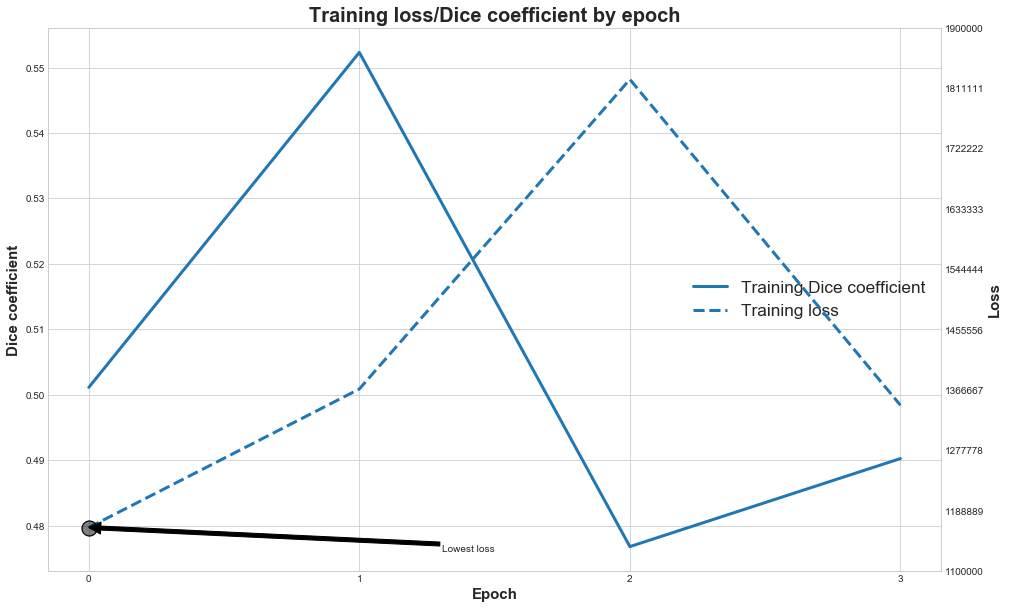

In [13]:
plot_training_history(hist,
                      show=True,
                      save_path=settings.OUTPUT_PATH + unet.title,
                      time_stamp=True,
                      metric="dice_coef")

# Perform pipeline test
Use the trained model on one sample in the training data set. This is just to perform pipeline testing during development.

Loading image HDF5: ../data/MSC8002/training3d/train3d_images.h5 with dtype = float16
Loading ground truth HDF5: ../data/MSC8002/training3d/train3d_groundtruths.h5 with dtype = uint8
Elapsed time: 0.14s


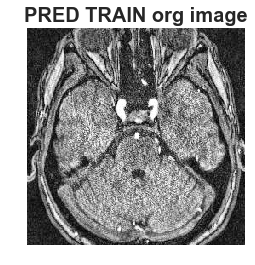

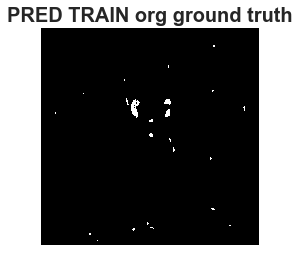

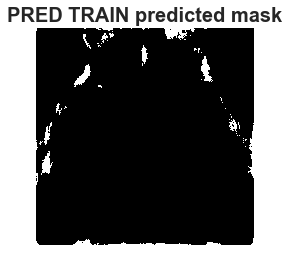

  original 1.0 dtype float16
  gr truth 255 dtype uint8
prediction 255 dtype float32


In [14]:
# Read images and ground truths
train_imgs = read_images(hdf5_paths[0], settings.HDF5_KEY, is_3D=True)
train_grndtr = read_groundtruths(hdf5_paths[1], settings.HDF5_KEY, is_3D=True)

# For pipeline testing only
predictions = model.predict(train_imgs, batch_size=settings.TRN_BATCH_SIZE, verbose=2)

# Transpose images and ground truths to the correct oder
train_imgs = np.transpose(train_imgs, axes=(0, 3, 1, 2, 4))
train_grndtr = np.transpose(train_grndtr, axes=(0, 3, 1, 2, 4))

# predictions = predictions
predictions_imgs = convert_pred_to_img_3d(predictions,
                                       threshold=settings.TRN_PRED_THRESHOLD,
                                       verbose=settings.VERBOSE)

show_image(np.squeeze(train_imgs[0, 0]), 'PRED TRAIN org image')
show_image(np.squeeze(train_grndtr[0, 0]), 'PRED TRAIN org ground truth')
show_image(np.squeeze(predictions_imgs[0, 0]), 'PRED TRAIN predicted mask')

print("  original {} dtype {}".format(np.max(train_imgs[0,0]), train_imgs[0,0].dtype))
print("  gr truth {} dtype {}".format(np.max(train_grndtr[0,0]), train_grndtr[0,0].dtype))
print("prediction {} dtype {}".format(np.max(predictions_imgs[0,0]), predictions[0,0].dtype))

# Training complete
The trained model is now ready to be applied to test MRI images using `VOLuLuS_test.ipynb`.

# References

*[Cicek]*: Özgün Çiçek, Ahmed Abdulkadir, Soeren S Lienkamp, Thomas Brox, and Olaf Ronneberger. 3d u-net: learning dense volumetric segmentation from sparse annotation. In *International Conference on Medical Image Computing and Computer- Assisted Intervention*, pages 424–432. Springer, 2016.